# Summary

# Imports

In [1]:
import pyarrow

In [2]:
import concurrent.futures
import itertools
import multiprocessing
import os
import os.path as op
import pickle
import subprocess
import tempfile
from functools import partial
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import seaborn as sns
import sqlalchemy as sa
from scipy import stats

from kmtools import py_tools, sequence_tools

In [3]:
%matplotlib inline

In [4]:
pd.set_option("max_columns", 100)

# Parameters

In [5]:
NOTEBOOK_PATH = Path('validation_training_stats')
NOTEBOOK_PATH

PosixPath('validation_training_stats')

In [6]:
OUTPUT_PATH = Path(os.getenv('OUTPUT_DIR', NOTEBOOK_PATH.name)).resolve()
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
OUTPUT_PATH

PosixPath('/scratch/strokach/datapkg/adjacency-net-v2/notebooks/validation_training_stats')

In [ ]:
proc = subprocess.run(["git", "rev-parse", "--short", "HEAD"], stdout=subprocess.PIPE)
GIT_REV = proc.stdout.decode().strip()
GIT_REV

In [7]:
TASK_ID = os.getenv("SLURM_ARRAY_TASK_ID")
TASK_COUNT = os.getenv("ORIGINAL_ARRAY_TASK_COUNT") or os.getenv("SLURM_ARRAY_TASK_COUNT")
NETWORK_NAME = os.getenv("NETWORK_NAME", GIT_REV)

TASK_ID = int(TASK_ID) if TASK_ID is not None else None
TASK_COUNT = int(TASK_COUNT) if TASK_COUNT is not None else None

TASK_ID, TASK_COUNT

(None, None)

In [8]:
DEBUG = "CI" not in os.environ    
DEBUG

True

In [9]:
if DEBUG:
    NETWORK_NAME = "9c5a963"
else:
    assert NETWORK_NAME is not None
    
NETWORK_NAME

'9c5a963'

In [10]:
# if DEBUG:
#     %load_ext autoreload
#     %autoreload 2

# `DATAPKG`

In [11]:
DATAPKG = {}

In [12]:
DATAPKG['uniparc-domain-wstructure'] = (
    Path(os.environ['DATAPKG_OUTPUT_DIR'])
    .joinpath("uniparc-domain-wstructure", "master")
)

In [13]:
DATAPKG['adjacency_net_v2'] = (
    Path(os.environ['DATAPKG_OUTPUT_DIR'])
    .joinpath("adjacency-net-v2", "master")
)

In [14]:
DATAPKG['hhsuite-wstructure'] = (
    Path(os.environ['DATAPKG_OUTPUT_DIR'])
    .joinpath("hhsuite-wstructure", "master")
)

# Network evaluation

In [15]:
%run trained_networks.ipynb

In [16]:
def predict_with_dcn_old(input_, network_info, network_state):
    from pagnn.prediction.dcn_old import Args, main
    args = Args(network_info=network_info, network_state=network_state)
    output_df = main(args, input_)
    return output_df

In [17]:
def predict_with_dcn(input_, network_info, network_state):
    from pagnn.prediction.dcn import Args, main
    args = Args(network_info=network_info, network_state=network_state)
    output_df = main(args, input_)
    return output_df

## Training statistics

### Load data

In [18]:
engine = sa.create_engine(f"sqlite:///{TRAINED_NETWORKS[NETWORK_NAME]['stats_db']}")

In [19]:
engine.table_names()

['info', 'stats']

In [20]:
info_df = pd.read_sql_table("info", engine)

In [21]:
stats_df = pd.read_sql_table("stats", engine)

### Extract data

In [22]:
display(stats_df.head(2))
print(len(stats_df))

,info_id,step,sequence_number,time_between_checkpoints,validation_gan_permute_80_1000-auc,validation_gan_exact_80_1000-auc,training_pos-auc,preds-mean,targets-mean,losses-mean,model_location,preds,targets,losses
0,0,0,0,NaN,0.517054,0.493989,0.489862,0.568220,0.015625,0.836556,models/model_000000000000.state,b'\x80\x04\x95\r\x90\x00\x00\x00\x00\x00\x00]\...,b'\x80\x04\x95\r\x90\x00\x00\x00\x00\x00\x00]\...,b'\x80\x04\x95\r\x00\x00\x00\x00\x00\x00\x00]\...
1,0,3,192,108.959814,NaN,NaN,0.493044,0.561452,0.015625,0.821453,None,b'\x80\x04\x95\r\x90\x00\x00\x00\x00\x00\x00]\...,b'\x80\x04\x95\r\x90\x00\x00\x00\x00\x00\x00]\...,b'\x80\x04\x95\r\x00\x00\x00\x00\x00\x00\x00]\...


920


In [23]:
stats_df['preds_list'] = stats_df['preds'].apply(pickle.loads)
stats_df['targets_list'] = stats_df['targets'].apply(pickle.loads)
stats_df['losses_list'] = stats_df['losses'].apply(pickle.loads)

In [24]:
def split_preds_pos_neg(stats_df):
    pos_mean_list = []
    neg_mean_list = []
    for pred, target in stats_df[['preds_list', 'targets_list']].values:
        pos_mean = np.array(pred)[np.array(target, dtype=np.bool)].mean()
        neg_mean = np.array(pred)[~np.array(target, dtype=np.bool)].mean()
        pos_mean_list.append(pos_mean)
        neg_mean_list.append(neg_mean)
    return pos_mean_list, neg_mean_list

if "pos_preds-mean" not in stats_df or "neg_preds-mean" not in stats_df:
    stats_df['pos_preds-mean'], stats_df['neg_preds-mean'] = split_preds_pos_neg(stats_df)

### Plot statistics

In [25]:
def plot_stats(x_col, y_col):
    if x_col not in stats_df.columns or y_col not in stats_df.columns:
        print("Data not available")
        return

    df = stats_df[[x_col, y_col]].dropna()

    with plt.rc_context({'figure.figsize': (6, 4), 'font.size': 14}):
        plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
        plt.plot(df[x_col], df[y_col], '-', label=y_col)
        plt.xlabel(x_col)
        plt.legend()

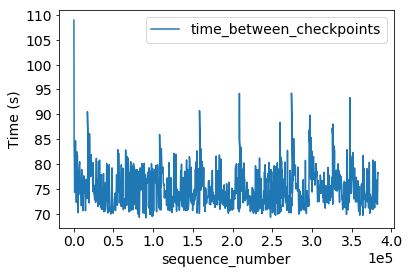

In [26]:
plot_stats("sequence_number", "time_between_checkpoints")
plt.ylabel("Time (s)")
None

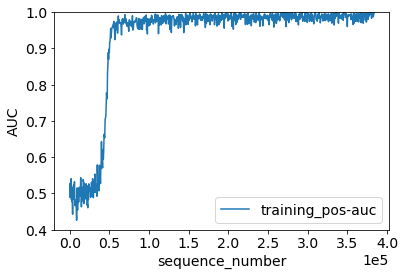

In [27]:
plot_stats("sequence_number", "training_pos-auc")
plt.ylabel("AUC")
plt.ylim(0.4, 1)
None

In [33]:
stats_df['training_pos-auc'][-10:]

910    0.994218
911    0.999752
912    0.983224
913    0.992839
914    0.994579
915    0.997570
916    0.996195
917    0.987088
918    0.992742
919    0.998117
Name: training_pos-auc, dtype: float64

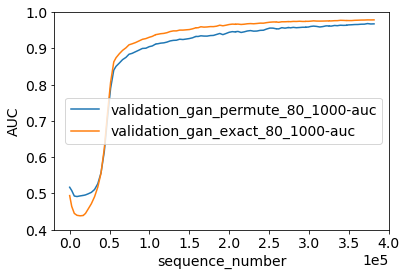

In [28]:
plot_stats("sequence_number", "validation_gan_permute_80_1000-auc")
plot_stats("sequence_number", "validation_gan_exact_80_1000-auc")
plt.ylabel("AUC")
plt.ylim(0.4, 1)
None

In [37]:
stats_df['validation_gan_permute_80_1000-auc'].dropna()[-10:]

836    0.964582
844    0.965026
852    0.965402
861    0.966006
870    0.966156
879    0.966915
888    0.967038
897    0.968668
906    0.967536
915    0.967893
Name: validation_gan_permute_80_1000-auc, dtype: float64

In [38]:
stats_df['validation_gan_exact_80_1000-auc'].dropna()[-10:]

836    0.977186
844    0.976967
852    0.976952
861    0.977662
870    0.977961
879    0.978331
888    0.978418
897    0.978819
906    0.978738
915    0.978864
Name: validation_gan_exact_80_1000-auc, dtype: float64

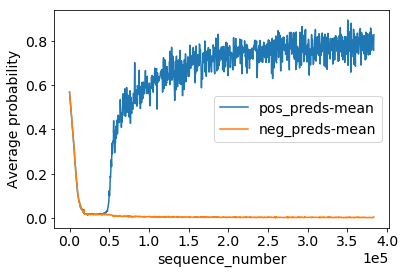

In [29]:
plot_stats("sequence_number", "pos_preds-mean")
plot_stats("sequence_number", "neg_preds-mean")
plt.ylabel("Average probability")
None